In [1]:
TFile *file = TFile::Open("../sample_data/g4e_output.root");
TTree *events = (TTree *) file->Get("events");

In [2]:
// You can call events->MakeSelector("G4eSelector")
// It will generate the next Tree reader and branches


TTreeReader fReader("events", file);

   // Readers to access the data (delete the ones you do not need).
TTreeReaderValue<ULong64_t>     event_id = {fReader, "event_id"};

// Hits collections
TTreeReaderValue<ULong64_t>     hit_count = {fReader, "hit_count"};
TTreeReaderArray<unsigned long> hit_id = {fReader, "hit_id"};
TTreeReaderArray<unsigned long> hit_trk_id = {fReader, "hit_trk_id"};
TTreeReaderArray<unsigned long> hit_ptr_id = {fReader, "hit_ptr_id"};
TTreeReaderArray<unsigned long> hit_parent_trk_id = {fReader, "hit_parent_trk_id"};
TTreeReaderArray<string>        hit_vol_name = {fReader, "hit_vol_name"};
TTreeReaderArray<double>        hit_x = {fReader, "hit_x"};
TTreeReaderArray<double>        hit_y = {fReader, "hit_y"};
TTreeReaderArray<double>        hit_z = {fReader, "hit_z"};
TTreeReaderArray<double>        hit_e_loss = {fReader, "hit_e_loss"};

// Tracks data
TTreeReaderValue<ULong64_t>     trk_count = {fReader, "trk_count"};
TTreeReaderArray<unsigned long> trk_id = {fReader, "trk_id"};
TTreeReaderArray<long>          trk_pdg = {fReader, "trk_pdg"};
TTreeReaderArray<unsigned long> trk_parent_id = {fReader, "trk_parent_id"};
TTreeReaderArray<long>          trk_create_proc = {fReader, "trk_create_proc"};
TTreeReaderArray<unsigned long> trk_level = {fReader, "trk_level"};
TTreeReaderArray<double>        trk_vtx_x = {fReader, "trk_vtx_x"};
TTreeReaderArray<double>        trk_vtx_y = {fReader, "trk_vtx_y"};
TTreeReaderArray<double>        trk_vtx_z = {fReader, "trk_vtx_z"};
TTreeReaderArray<double>        trk_vtx_dir_x = {fReader, "trk_vtx_dir_x"};
TTreeReaderArray<double>        trk_vtx_dir_y = {fReader, "trk_vtx_dir_y"};
TTreeReaderArray<double>        trk_vtx_dir_z = {fReader, "trk_vtx_dir_z"};
TTreeReaderArray<double>        trk_mom = {fReader, "trk_mom"};

// 'Copy' of generated particle data
TTreeReaderValue<ULong64_t>     gen_prt_count = {fReader, "gen_prt_count"};
TTreeReaderArray<unsigned long> gen_prt_id = {fReader, "gen_prt_id"};
TTreeReaderArray<unsigned long> gen_prt_vtx_id = {fReader, "gen_prt_vtx_id"};
TTreeReaderArray<unsigned long> gen_prt_pdg = {fReader, "gen_prt_pdg"};
TTreeReaderArray<unsigned long> gen_prt_trk_id = {fReader, "gen_prt_trk_id"};
TTreeReaderArray<double>        gen_prt_charge = {fReader, "gen_prt_charge"};
TTreeReaderArray<double>        gen_prt_dir_x = {fReader, "gen_prt_dir_x"};
TTreeReaderArray<double>        gen_prt_dir_y = {fReader, "gen_prt_dir_y"};
TTreeReaderArray<double>        gen_prt_dir_z = {fReader, "gen_prt_dir_z"};
TTreeReaderArray<double>        gen_prt_tot_mom = {fReader, "gen_prt_tot_mom"};
TTreeReaderArray<double>        gen_prt_tot_e = {fReader, "gen_prt_tot_e"};
TTreeReaderArray<double>        gen_prt_time = {fReader, "gen_prt_time"};
TTreeReaderArray<double>        gen_prt_polariz_x = {fReader, "gen_prt_polariz_x"};
TTreeReaderArray<double>        gen_prt_polariz_y = {fReader, "gen_prt_polariz_y"};
TTreeReaderArray<double>        gen_prt_polariz_z = {fReader, "gen_prt_polariz_z"};
TTreeReaderValue<ULong64_t>     gen_vtx_count = {fReader, "gen_vtx_count"};
TTreeReaderArray<unsigned long> gen_vtx_id = {fReader, "gen_vtx_id"};
TTreeReaderArray<unsigned long> gen_vtx_part_count = {fReader, "gen_vtx_part_count"};
TTreeReaderArray<double>        gen_vtx_x = {fReader, "gen_vtx_x"};
TTreeReaderArray<double>        gen_vtx_y = {fReader, "gen_vtx_y"};
TTreeReaderArray<double>        gen_vtx_z = {fReader, "gen_vtx_z"};
TTreeReaderArray<double>        gen_vtx_time = {fReader, "gen_vtx_time"};
TTreeReaderArray<double>        gen_vtx_weight = {fReader, "gen_vtx_weight"};



In [3]:
double mass_electron = 0.00051099895;

// XY of hits in ce_EMCAL
auto h2_xy_hits_elcap = new TH2I("xy_hits_elcap", "X,Y hits in Electron Endcap EMCAL", 200, -1500, 1500, 200, -1500, 1500);

auto h1_el_e_tot = new TH1D("rec_el_e_tot", "Energy of the recoil electron", 500, 0., 30.);
     h1_el_e_tot->GetXaxis()->SetTitle("E [GeV]");



In [4]:
// (!!!) THIS EVENT LOOP METHOD IS SLOW IN ROOT INTERPRETTER
// It is only for a showcase

// Event loop (use pool or fancier TDataFrame for multithreaded processing, )
// Here is the examples of multicore usage:
// https://root.cern.ch/root/html608/dir_b2d2b4e27d077f7d4f8f12bfa35378a6.html
// And here is the TDataFrame
// https://root.cern.ch/doc/v610/classROOT_1_1Experimental_1_1TDataFrame.html

// Now we try to keep things simple for this example:


// Loop over all entries of the TTree or TChain.
size_t events_numer = 0;

while (fReader.Next()) {
    if(++events_numer>1000) break; // The next operation may take time so we want to limit NEvents

    
    // We will use it to get tracks that have hits in ion EMCAL
    std::unordered_set<uint64_t> track_ids_in_ecap_emcal;
    
    // Read basic values
    auto hits_count = static_cast<size_t>(*hit_count.Get());         // Number of hits
    auto tracks_count = static_cast<size_t>(*trk_count.Get());       // Number of tracks
        
    // Iterate over hits
    for(size_t i=0; i < hits_count; i++){
        
        // This is is of a track that made this hit
        uint64_t parent_track_id = static_cast<uint64_t>(hit_trk_id[i]);
            
        double x = hit_x[i];
        double y = hit_y[i];
        double z = hit_z[i];
            
        double e_loss = hit_e_loss[i];
            
        // This is a volume name of a hit
        std::string vol_name = static_cast<std::string>(hit_vol_name[i]);
        
        // Check that the name starts with "ci_EMCAL"
        if(vol_name.rfind("ci_EMCAL", 0) == 0) {
            
            track_ids_in_ecap_emcal.insert(parent_track_id);
            h2_xy_hits_elcap->Fill(x, y);
        }
    }
    
    // Iterate over tracks
    for(size_t i=0; i < hits_count; i++){
        if (trk_pdg[i] != 11) continue;       // Take only electrons for now
        if (trk_parent_id[i] != 0) continue;  // Take only particles from a generator
                
        // Check track has hits in ce_EMCAL
        if (!track_ids_in_ecap_emcal.count(trk_id[i])) continue;
        
        // Construct TLorenz vector
        double px = trk_vtx_dir_x[i] * trk_mom[i];
        double py = trk_vtx_dir_y[i] * trk_mom[i];
        double pz = trk_vtx_dir_z[i] * trk_mom[i];

        TLorentzVector lv;
        lv.SetXYZM(px, py, pz, mass_electron);
        h1_el_e_tot->Fill(lv.Energy());
    }
}

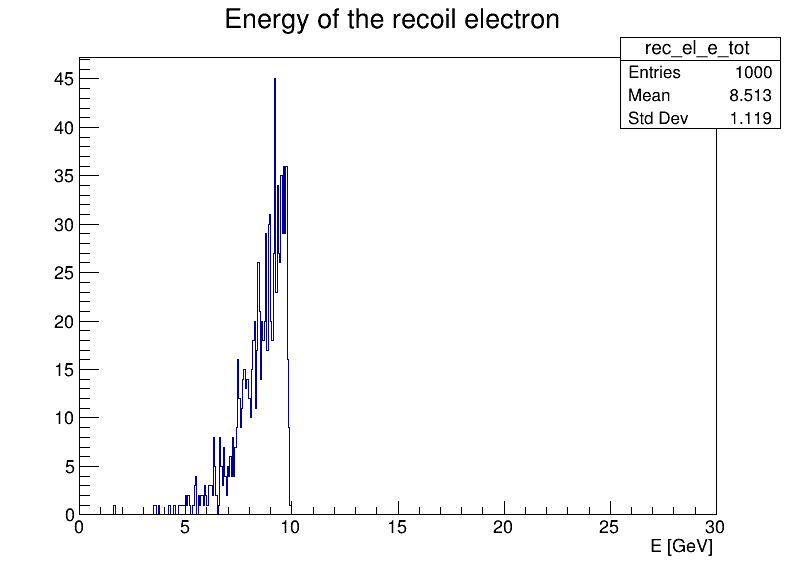

In [5]:
auto c1 = new TCanvas("c1","The Canvas Title",800,600);
h1_el_e_tot->Draw();
c1->Draw();




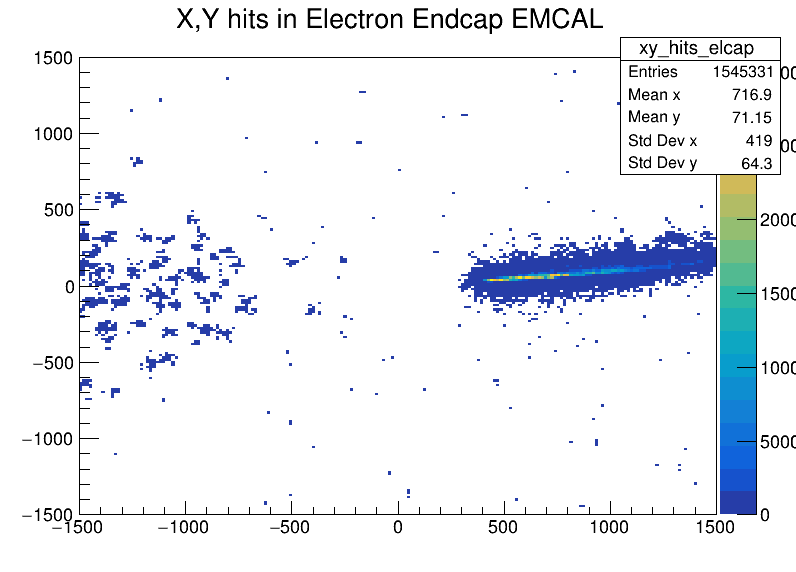

In [6]:
TCanvas c2("c2","The Canvas Title",800,600);
h2_xy_hits_elcap->Draw("colz");
c2.Draw();